<a href="https://colab.research.google.com/github/Raihandany/ML_Ganjil_2023/blob/main/Jobsheet10_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **STEP 1 - Import Library**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# **STEP 2 - Setup input pipeline**

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This is one of my favorite Govinda movies of all time and best film of 1994. David Dhawan does a great job in directing this movie, he makes it funny and adds family drama. Govinda is Excellent as Raja Babu and gives a great performance. Karishma Kapoor is an actress i hate, this film she is a little less annoying but still annoys in some scenes. Kader Khan is a maestro in acting and yet gives a superb performance. Aroona Irani is terrific as the mother and gives a outstanding performance. Shakti Kapoor is brilliant as Nandu the sidekick. This film has Comedy, action, family drama and romance a full on entertainer.'
 b"Dressed to Kill (1980) is a mystery horror film from Brian De Palma and it really works.The atmosphere is right there.The atmosphere that makes you scared.And isn't that what a horror film is supposed to do.All the actors are in the right places.Michael Caine is perfect as Dr. Robert Elliott, the shrink with a little secret.Angie Dickinson as Kate Miller, the 

## **STEP 3 - Create a Text Encoder**

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,  29, ...,   0,   0,   0],
       [  1,   6, 502, ...,   0,   0,   0],
       [  1, 253,  74, ...,   0,   0,   0]])

In [19]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This is one of my favorite Govinda movies of all time and best film of 1994. David Dhawan does a great job in directing this movie, he makes it funny and adds family drama. Govinda is Excellent as Raja Babu and gives a great performance. Karishma Kapoor is an actress i hate, this film she is a little less annoying but still annoys in some scenes. Kader Khan is a maestro in acting and yet gives a superb performance. Aroona Irani is terrific as the mother and gives a outstanding performance. Shakti Kapoor is brilliant as Nandu the sidekick. This film has Comedy, action, family drama and romance a full on entertainer.'
Round-trip:  this is one of my favorite [UNK] movies of all time and best film of [UNK] david [UNK] does a great job in directing this movie he makes it funny and [UNK] family drama [UNK] is excellent as [UNK] [UNK] and gives a great performance [UNK] [UNK] is an actress i hate this film she is a little less annoying but still [UNK] in some scenes [UNK] [UNK] i

## **STEP 4 - Create Model**

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [22]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-4.9470458e-05]


In [24]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 89ms/step
[-4.9471622e-05]


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## **STEP 5 - Train Model**

In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 104ms/step - loss: 0.6514 - accuracy: 0.5574 - val_loss: 0.5067 - val_accuracy: 0.7661
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.4288 - accuracy: 0.8010 - val_loss: 0.3892 - val_accuracy: 0.8245
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3535 - accuracy: 0.8416 - val_loss: 0.3514 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3291 - accuracy: 0.8535 - val_loss: 0.3397 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3180 - accuracy: 0.8616 - val_loss: 0.3275 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3095 - accuracy: 0.8662 - val_loss: 0.3312 - val_accuracy: 0.8490
Epoch 7/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3052 - accuracy: 0.8690 - val_loss: 0.3325 - val_accuracy

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3148 - accuracy: 0.8578
Test Loss: 0.314782053232193
Test Accuracy: 0.8578400015830994


(0.0, 0.6690387025475502)

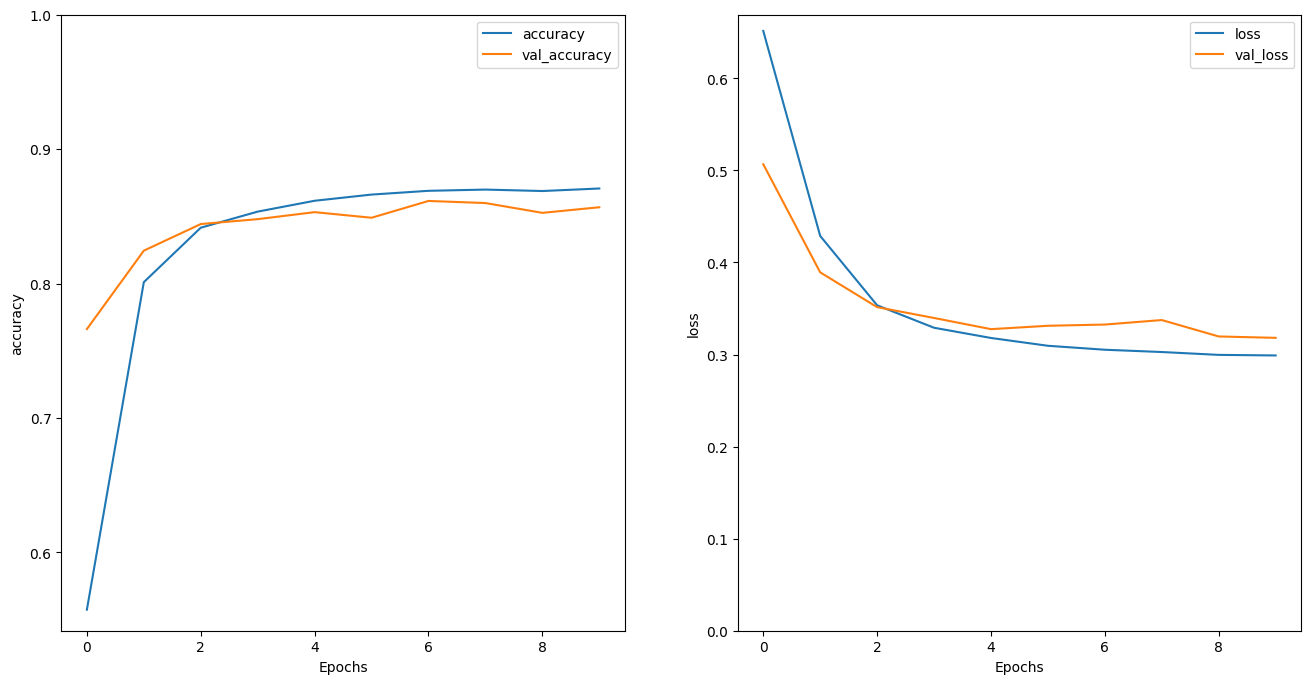

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [31]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [32]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [34]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 156ms/step - loss: 0.6185 - accuracy: 0.5992 - val_loss: 0.4296 - val_accuracy: 0.8229
Epoch 2/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3821 - accuracy: 0.8336 - val_loss: 0.3477 - val_accuracy: 0.8328
Epoch 3/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3390 - accuracy: 0.8528 - val_loss: 0.3346 - val_accuracy: 0.8458
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3181 - accuracy: 0.8637 - val_loss: 0.3481 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3141 - accuracy: 0.8658 - val_loss: 0.3230 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3066 - accuracy: 0.8701 - val_loss: 0.3347 - val_accuracy: 0.8443
Epoch 7/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3038 - accuracy: 0.8704 - val_loss: 0.3174 - val_ac

In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3293 - accuracy: 0.8531
Test Loss: 0.32926955819129944
Test Accuracy: 0.8531200289726257


In [36]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8262631]]


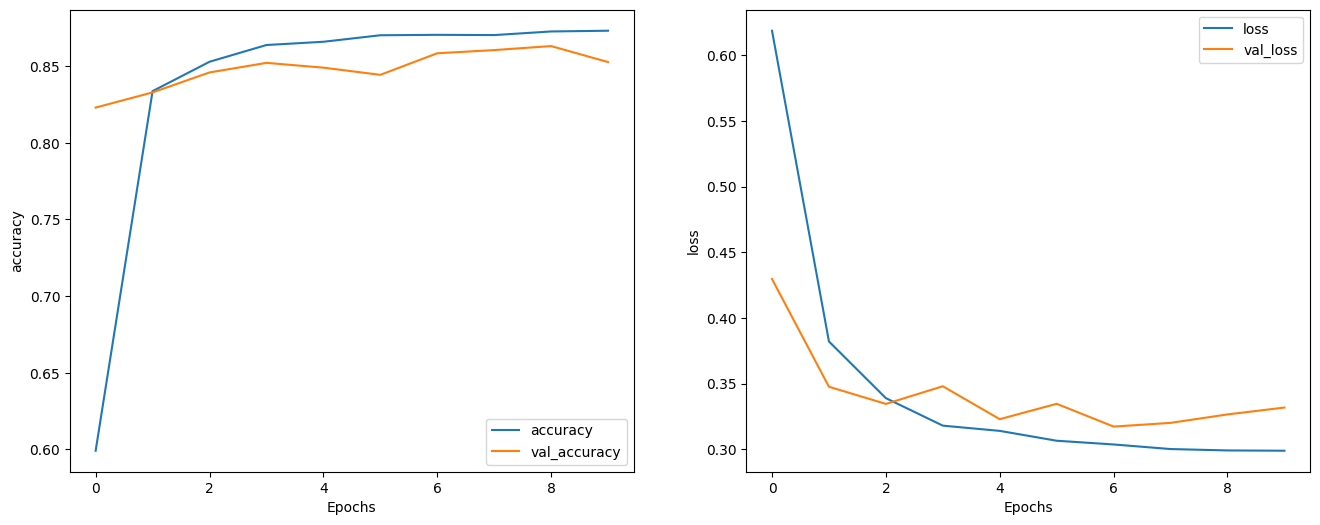

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **LAB WORK 2**

# **STEP 1 - Setup**

Import TenserFlow

In [1]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## **STEP 2 - Text Processing**

Vectorize Text

In [6]:
example_texts = ['abcdefg', 'xyz']
chars= tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [7]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [8]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [9]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [10]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [11]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [12]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

Prediction

Creating the Training Set and Target

In [13]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [14]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [15]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [16]:
seq_length = 100

In [17]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [20]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(ids_from_chars(ids), axis=-1).numpy()

In [21]:
for seq in sequences.take(5):
    print(text_from_ids(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [22]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [23]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [24]:
dataset = sequences.map(split_input_target)

In [26]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example))
  print("Target:", text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Creating Batch Training

In [27]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# **STEP 3 - Creating Model**

In [28]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [29]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [30]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# **STEP 4 - Test and Model**

In [31]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [32]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [34]:
sampled_indices

array([12, 12, 62, 16, 64, 57, 23, 51, 61, 18, 25, 47,  6, 49, 39, 29, 12,
       65, 12,  1, 42, 20, 24, 48, 20, 39, 37, 41, 31, 50,  0, 38, 58, 65,
       26, 31, 56, 14,  7, 54, 15,  4, 54, 54, 26, 60, 61, 16, 33, 48, 34,
       42,  7, 12, 39, 46, 27, 17, 10, 32, 44, 24, 17,  3,  0, 50, 37, 57,
       16, 35, 61,  5, 13, 33,  8,  7, 61, 26, 41, 28, 34, 52, 45, 32, 40,
       55, 15, 61, 14,  6, 60, 41, 42, 25, 28, 24, 63, 10, 35,  4])

In [35]:
print("Input:\n", text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices))

Input:
 b'p wears at feasts, keep with Bohemia\nAnd with your queen. I am his cupbearer:\nIf from me he have who'

Next Char Predictions:
 b";;wCyrJlvELh'jZP;z;\ncGKiGZXbRk[UNK]YszMRqA,oB$ooMuvCTiUc,;ZgND3SeKD![UNK]kXrCVv&?T-,vMbOUmfSapBvA'ubcLOKx3V$"


# **STEP 5 - Train the Model**

Additional optimizer and loss function

In [36]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [37]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.188347, shape=(), dtype=float32)


In [38]:
tf.exp(example_batch_mean_loss).numpy()

65.913734

In [39]:
model.compile(optimizer='adam', loss=loss)

Configure Checkpoints

In [40]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Run the Training Process

In [41]:
EPOCHS=20

In [42]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 13s 52ms/step - loss: 2.7218
Epoch 2/20
172/172 [==============================] - 11s 50ms/step - loss: 1.9923
Epoch 3/20
172/172 [==============================] - 11s 51ms/step - loss: 1.7069
Epoch 4/20
172/172 [==============================] - 10s 51ms/step - loss: 1.5454
Epoch 5/20
172/172 [==============================] - 10s 51ms/step - loss: 1.4464
Epoch 6/20
172/172 [==============================] - 10s 51ms/step - loss: 1.3781
Epoch 7/20
172/172 [==============================] - 11s 52ms/step - loss: 1.3267
Epoch 8/20
172/172 [==============================] - 12s 52ms/step - loss: 1.2820
Epoch 9/20
172/172 [==============================] - 11s 52ms/step - loss: 1.2410
Epoch 10/20
172/172 [==============================] - 11s 52ms/step - loss: 1.2015
Epoch 11/20
172/172 [==============================] - 11s 53ms/step - loss: 1.1617
Epoch 12/20
172/172 [==============================] - 11s 52ms/step - loss: 1.1197
E

In [1]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

NameError: ignored